In [34]:
import configparser
import time

import pandas as pd
import numpy as np
import tiktoken
import ast
import openai
import matplotlib
import matplotlib.pylab as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from openai.embeddings_utils import get_embedding

config = configparser.ConfigParser()
config.read('../config.ini')
openai.api_key = config.get('Openai', 'api_key')


In [29]:
# 加载数据集

files_path = "../datas/fine_food_reviews_3.csv"
df = pd.read_csv(files_path, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = ("Title：" + df.Summary.str.strip() + "content：" + df.Text.str.strip())


In [30]:
df["combined"]

0    Title：where does one  start...and stop... with...
1    Title：Arrived in piecescontent：不得不说这家店的环境其实还不错...
2    Title：The Music Bar音乐吧content：“ 打卡位于望京凯悦酒店一楼的 ...
3    Title：The Music Bar音乐吧content：酒单上的威士忌酸88~结账到最后...
4    Title：The Magic Barcontent：'服务满分，环境中规中矩，音乐真心受不...
Name: combined, dtype: object

In [31]:
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"
max_tokens = 8000

In [35]:
embeddings_list = []

for index,value in enumerate(df.combined):
    print(index, value)
    if index==3:
        time.sleep(60)
    embedding = get_embedding(value, engine=embedding_model)
    embeddings_list.append(embedding)
df['embedding'] = embeddings_list

# df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
output_datapath = "../datas/fine_food_reviews_with_embeddings_3.csv"
#
df.to_csv(output_datapath)

0 Title：where does one  start...and stop... with a treat like thiscontent：下雨天先到中星城避个雨，正好一层有这家COSTA COFFEE，也就顺便打个卡。就在商场的入口处，开放式的餐区与商场合体，冬天的话暖气不足就感觉还是有点冷，不能脱掉外套。这样就需要来杯热美式咖啡来暖暖身体了。大杯的量很足，喝了半天也没喝完[偷笑]。
1 Title：Arrived in piecescontent：不得不说这家店的环境其实还不错，但是因为层高的关系，又是一楼对着门，所以感觉好冷，在连续下雨的天气里，那个体感可是很不好。一杯美式咖啡，可以选择上等咖啡豆，➕5元，试试吧，口感上更烘培更深度，个人觉得一般。
2 Title：The Music Bar音乐吧content：“ 打卡位于望京凯悦酒店一楼的 Music bar，环境真的很舒服，相信大多数人都会喜欢这种feel经典格兰杰跟大都会非常好喝，炸小河虾跟盐炯银杏十分美味，下酒够了 推荐:炸小河虾“
3 Title：The Music Bar音乐吧content：酒单上的威士忌酸88~结账到最后，告诉升级版一定要睁眼看看结账单!108! 整个这个强盗啊!
4 Title：The Magic Barcontent：'服务满分，环境中规中矩，音乐真心受不了，清吧你请乐队来唱一晚上，几个人想聊聊天一个字也听不到。乐队休息的时候音乐放得比夜店音乐还大，震得想吐，不会再来......'


In [36]:
# files_path="../datas/fine_food_reviews_with_embeddings_1k.csv"
files_path="../datas/fine_food_reviews_with_embeddings_3.csv"
df_embeded = pd.read_csv(files_path,index_col=0)

# 将字符串转换为向量
df_embeded["embedding_vec"] = df_embeded["embedding"].apply(ast.literal_eval)

In [37]:
type(df_embeded["embedding_vec"])

pandas.core.series.Series

In [38]:
assert df_embeded['embedding_vec'].apply(len).nunique() == 1

In [39]:
matrix = np.vstack(df_embeded['embedding_vec'].values)

In [ ]:
matrix.shape

In [42]:
tsne = TSNE(n_components=2, perplexity=2, random_state=42, init='random', learning_rate=200)

In [43]:
vis_dims = tsne.fit_transform(matrix)

In [56]:
vis_dims.shape

(5, 2)

In [44]:
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
# colors = ["red", "orange", "green", "yellow", "blue"]

In [45]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embeded.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embeded.Score.values)

[Text(1, 0, 'red - Score:1'),
 Text(1, 1, 'darkorange - Score:2'),
 Text(1, 2, 'gold - Score:3'),
 Text(1, 3, 'turquoise - Score:4'),
 Text(1, 4, 'darkgreen - Score:5')]

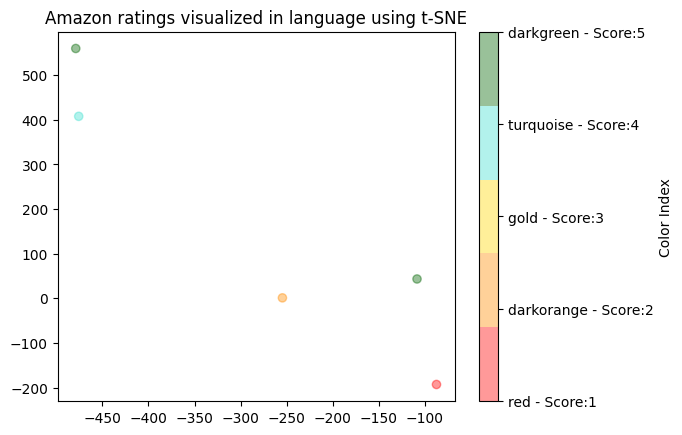

In [46]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.4)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

# 添加颜色指标对应关系
color_labels = ["red - Score:1", "darkorange - Score:2", "gold - Score:3", "turquoise - Score:4", "darkgreen - Score:5"]
plt.colorbar(ticks=range(len(color_labels)), label="Color Index").ax.set_yticklabels(color_labels)

In [47]:
# t-SNE降维后，产生了大约3个大类，其中1个大类的评论大多是负面的。即：red - Score:1
4. 使用 K-Means 聚类，然后使用 t-SNE 可视化

SyntaxError: invalid character '，' (U+FF0C) (3948827889.py, line 2)

In [48]:
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df_embeded['Cluster'] = kmeans.labels_


/Users/yangshengqin/my_pyenv/AINote/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [49]:
df_embeded['Cluster']

0    2
1    0
2    1
3    3
4    1
Name: Cluster, dtype: int32

In [ ]:
colors = ["red", "green", "blue", "purple"]
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)
# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

In [ ]:
vis_data

In [ ]:
x

In [ ]:
# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embeded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

In [ ]:
K-MEANS 聚类可视化效果，4类：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论。

In [52]:
from openai.embeddings_utils import get_embedding, cosine_similarity

In [ ]:
type(df_embeded["embedding_vec"][0])


In [50]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [53]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
# res = search_reviews(df_embeded, 'delicious beans', n=3)
res = search_reviews(df_embeded, '音乐', n=3)

Title：The Magic Barcontent：'服务满分，环境中规中矩，音乐真心受不了，清吧你请乐队来唱一晚上，几个人想聊聊天一个字也听不到。乐队休息的时候音乐放得比夜店音乐还大，震得想吐，不会再来......'

Title：The Music Bar音乐吧content：“ 打卡位于望京凯悦酒店一楼的 Music bar，环境真的很舒服，相信大多数人都会喜欢这种feel经典格兰杰跟大都会非常好喝，炸小河虾跟盐炯银杏十分美味，下酒够了 推荐:炸小河虾“

Title：The Music Bar音乐吧content：酒单上的威士忌酸88~结账到最后，告诉升级版一定要睁眼看看结账单!108! 整个这个强盗啊!



In [54]:

# 选一条类别3的评论
df_embeded['combined'][0]


'Title：where does one  start...and stop... with a treat like thiscontent：下雨天先到中星城避个雨，正好一层有这家COSTA COFFEE，也就顺便打个卡。就在商场的入口处，开放式的餐区与商场合体，冬天的话暖气不足就感觉还是有点冷，不能脱掉外套。这样就需要来杯热美式咖啡来暖暖身体了。大杯的量很足，喝了半天也没喝完[偷笑]。'

In [55]:
res = search_reviews(df_embeded, df_embeded['combined'][0], n=1)

Title：where does one  start...and stop... with a treat like thiscontent：下雨天先到中星城避个雨，正好一层有这家COSTA COFFEE，也就顺便打个卡。就在商场的入口处，开放式的餐区与商场合体，冬天的话暖气不足就感觉还是有点冷，不能脱掉外套。这样就需要来杯热美式咖啡来暖暖身体了。大杯的量很足，喝了半天也没喝完[偷笑]。

